In [1]:
%pip install sentence-transformers

StatementMeta(, 0a32367b-eb7d-4991-8bd9-0f8a55b6ab5d, -1, Finished, Available)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.1 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 40.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 88.8 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 140.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 183.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 94.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 178.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 99.0 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 7.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 MB 28.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 MB 41.8 MB/s eta 0:00:0000:0100:01
    

In [2]:
for par in ["spark.executor.memory", "spark.executor.cores", "spark.executor.memoryOverhead", 
            "spark.sql.execution.arrow.pyspark.enabled", "spark.kryoserializer.buffer.max"]:
    print(par, ":", spark.conf.get(par))

StatementMeta(, 0a32367b-eb7d-4991-8bd9-0f8a55b6ab5d, 9, Finished, Available)

spark.executor.memory : 56g
spark.executor.cores : 8
spark.executor.memoryOverhead : 384
spark.sql.execution.arrow.pyspark.enabled : true
spark.kryoserializer.buffer.max : 128m


In [3]:
from py4j.protocol import Py4JError

# Use vorder-enabled delta parquet
spark.conf.set("spark.sql.parquet.vorder.enabled", "true")


StatementMeta(, 0a32367b-eb7d-4991-8bd9-0f8a55b6ab5d, 10, Finished, Available)

In [4]:
import pandas as pd
import numpy as np
import os
import time
import pickle
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split

from sentence_transformers import SentenceTransformer
sentxformer = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

CSV_FILE = '/lakehouse/default/Files/mladsdata/ai_Posts.csv'

StatementMeta(, 0a32367b-eb7d-4991-8bd9-0f8a55b6ab5d, 11, Finished, Available)

In [5]:
os.listdir('/lakehouse/default/Files')

StatementMeta(, 0a32367b-eb7d-4991-8bd9-0f8a55b6ab5d, 12, Finished, Available)

['ai_Posts.csv']

In [6]:
ai_posts = pd.read_csv(CSV_FILE)

def combine_title_and_body(title, body):
    # I'm having trouble getting over the fact that a missing string has a numeric type.
    if title==title: # not NaN
        text = title + ' ' + body
    elif body == body:
        text = body
    else:
        text = ''
    return str(text)

# Collect title and body into a single column cleverly named 'text
ai_posts['text'] = [ combine_title_and_body(row.title, row.body) for idx, row in ai_posts.iterrows() ]

# Drop any rows where the text field is empty
ai_posts = ai_posts[ai_posts.text != '']

ai_posts

StatementMeta(, 0a32367b-eb7d-4991-8bd9-0f8a55b6ab5d, 13, Finished, Available)

,topic,title,body,tags,last_activity_date,text
0,ai,"What is ""backprop""?","What does ""backprop"" mean? Is the ""backprop"" t...",neural-networks;backpropagation;terminology;de...,2021-07-08T10:45:23.250,"What is ""backprop""? What does ""backprop"" mean?..."
1,ai,How does noise affect generalization?,Does increasing the noise in data help to impr...,neural-networks;machine-learning;statistical-a...,2019-02-23T22:36:37.133,How does noise affect generalization? Does inc...
2,ai,NaN,"""Backprop"" is the same as ""backpropagation"": i...",NaN,2016-08-02T15:40:24.820,"""Backprop"" is the same as ""backpropagation"": i..."
3,ai,How to find the optimal number of neurons per ...,"When you're writing your algorithm, how do you...",neural-networks;hyperparameter-optimization;ar...,2021-01-19T23:54:07.813,How to find the optimal number of neurons per ...
4,ai,Are humans intelligent according to the defini...,Given the following definition of an intellige...,philosophy;definitions;intelligent-agent,2019-06-15T18:29:55.520,Are humans intelligent according to the defini...
...,...,...,...,...,...,...
23174,ai,NaN,The purpose of evaluating the state and action...,NaN,2022-12-04T16:24:35.890,The purpose of evaluating the state and action...
23175,ai,NaN,"In machine translation, convolution is a techn...",NaN,2022-12-04T16:29:33.587,"In machine translation, convolution is a techn..."
23176,ai,NaN,One of the key features of ChatGPT is its abil...,NaN,2022-12-04T16:32:24.353,One of the key features of ChatGPT is its abil...
23177,ai,My cross entropy loss gradient calculation is ...,Given a neural network model for Covid-19 clas...,neural-networks;homework,2022-12-04T16:49:03.533,My cross entropy loss gradient calculation is ...


In [7]:
# Note that text entries are not completely unique:
from collections import Counter
Counter(ai_posts['text']).most_common(5)

StatementMeta(, 0a32367b-eb7d-4991-8bd9-0f8a55b6ab5d, 14, Finished, Available)

[('For question about Multi Layer Perceptron model/architecture, its training and other related details and parameters associated with the model. ',
  2),
 ('For references to "Artificial Intelligence: A Modern Approach" and the work of Russell & Norvig in general.',
  2),
 ('For more info, see, for example, https://en.wikipedia.org/wiki/Symbolic_artificial_intelligence.\n',
  2),
 ('Check more in Wikipedia\n', 2),
 ('What is "backprop"? What does "backprop" mean? Is the "backprop" term basically the same as "backpropagation" or does it have a different meaning?\n',
  1)]

# Compute semantic embeddings for text

In [8]:
# sentxformer.encode(ai_posts['text'].values).tolist() # Do not try this at home without a GPU!

def get_embeddings_sdf(input_sdf, text_col, num_partitions=56, sentxformer_model_name='paraphrase-MiniLM-L6-v2'):
    
    import torch
    from sentence_transformers import SentenceTransformer
    from pyspark.sql.types import StructType, StructField, StringType, ArrayType, DoubleType

    sentxformer = SentenceTransformer('sentence-transformers/' + sentxformer_model_name)

    def get_distinct_values(df, col_name):
        return df[ [col_name] ].groupBy(df[col_name]).count().orderBy(['count'], ascending = [False])

    def get_embeddings_for_partition(partitionData):
        torch.set_num_threads(1) # Each job already runs multiple threads in parallel
        text_list = [row[text_col] for row in partitionData]
        embeddings_list = sentxformer.encode(text_list).tolist()
        return iter(zip(text_list, embeddings_list))

    # Find the distinct text values
    distinct_text_sdf = get_distinct_values(input_sdf, "text")

    # Map the get_embeddings_for_partition function over the partitions of the text_table
    embeddings_rdd = distinct_text_sdf.rdd.repartition(num_partitions).mapPartitions( get_embeddings_for_partition )

    # the output schema needs text and embedding columns
    embedding_col = text_col + '_embedding'
    schema = StructType([
        StructField(text_col, StringType(), True),
        StructField(embedding_col, ArrayType(DoubleType()), True)
    ])
 
    # Convert the rdd to a Spark dataframe
    embeddings_sdf = spark.createDataFrame(embeddings_rdd, schema)

    return embeddings_sdf



ai_posts_sdf = spark.createDataFrame(ai_posts)

ai_posts_text_embeddings_sdf = get_embeddings_sdf(ai_posts_sdf, text_col="text")

# ai_posts_text_embeddings_sdf.toPandas() # This forces evaluation of the entire dataset and would take about 2 min 40 sec, but don't do it yet.


StatementMeta(, 0a32367b-eb7d-4991-8bd9-0f8a55b6ab5d, 15, Finished, Available)

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:604: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.


StatementMeta(, 0a32367b-eb7d-4991-8bd9-0f8a55b6ab5d, 40, Finished, Available)

In [9]:
ai_posts_text_embeddings_sdf.show()

StatementMeta(, 0a32367b-eb7d-4991-8bd9-0f8a55b6ab5d, 16, Finished, Available)

+--------------------+--------------------+
|                text|      text_embedding|
+--------------------+--------------------+
|Are ANNs just hig...|[-0.3368662595748...|
|Yes, it is possib...|[0.17617964744567...|
|Which methods or ...|[-0.1868504434823...|
|"Life" is a defin...|[-0.3500498831272...|
|Usually softmax m...|[-0.2591229081153...|
|Relation between ...|[-0.0082788467407...|
|Basically Machine...|[-0.3445831835269...|
|Which predictive ...|[-0.2596582770347...|
|Yes, this is a ra...|[-0.2227929681539...|
|Is it beneficial ...|[0.11169280111789...|
|\nThe $TD(0)$ alg...|[-0.0171618815511...|
|OpenAI Spinning U...|[-0.2032575011253...|
|We usually optimi...|[-0.0038539785891...|
|What is the diffe...|[-0.0587734952569...|
|Yes there is! If ...|[-0.1253008693456...|
|What are the main...|[-0.1375465691089...|
|For questions rel...|[-0.3989367187023...|
|On-policy RL algo...|[-0.2904274165630...|
|You could perhaps...|[0.11327473074197...|
|In laymen's terms...|[0.0310951

In [10]:
# Join the embeddings to the 'ai_posts' dataframe, and save to a table.

ai_posts_sdf.join(ai_posts_text_embeddings_sdf, on='text') \
    .write.format("delta").mode("overwrite").option("overwriteSchema", "true") \
    .saveAsTable('ai_posts_featurized')

StatementMeta(, 0a32367b-eb7d-4991-8bd9-0f8a55b6ab5d, 17, Finished, Available)

In [11]:
%%sql

-- select count(*) from ai_posts_featurized -- 22515

select * from ai_posts_featurized limit 10

StatementMeta(, 0a32367b-eb7d-4991-8bd9-0f8a55b6ab5d, 18, Finished, Available)

<Spark SQL result set with 10 rows and 7 fields>

In [12]:
ai_posts_featurized = spark.sql("select * from ai_posts_featurized").toPandas()

# Convert date strings to datetime
ai_posts_featurized['last_activity_date'] = pd.to_datetime(ai_posts_featurized['last_activity_date'])

# Re-number the lines
ai_posts_featurized = ai_posts_featurized.reset_index().rename(columns={'index': 'post_id'})

ai_posts_featurized

StatementMeta(, 0a32367b-eb7d-4991-8bd9-0f8a55b6ab5d, 19, Finished, Available)

,post_id,text,topic,title,body,tags,last_activity_date,text_embedding
0,0,\n...why does everyone have to repeat the effo...,ai,None,\n...why does everyone have to repeat the effo...,None,2017-11-22T08:50:19.127,"[-0.24489064514636993, -0.3754422068595886, -0..."
1,1,\nAm I right in thinking that because there ar...,ai,None,\nAm I right in thinking that because there ar...,None,2020-02-22T02:46:17.837,"[-0.09475952386856079, -0.26205575466156006, 0..."
2,2,"\nArtificial consciousness (AC), also known as...",ai,None,"\nArtificial consciousness (AC), also known as...",None,2020-07-14T15:13:09.560,"[-0.12401305884122849, -0.2516554892063141, -0..."
3,3,\nBUT there are 2 different attention layers a...,ai,None,\nBUT there are 2 different attention layers a...,None,2020-11-20T12:56:33.260,"[0.03800094500184059, -0.08189216256141663, -0..."
4,4,"\nBecause the Q value is different, I don't se...",ai,None,"\nBecause the Q value is different, I don't se...",None,2019-02-02T09:45:29.497,"[-0.5024558901786804, -0.10301662981510162, -0..."
...,...,...,...,...,...,...,...,...
22510,22510,https://en.wikipedia.org/wiki/Ethics\nhttps://...,ai,None,https://en.wikipedia.org/wiki/Ethics\nhttps://...,None,2018-01-26T20:58:15.463,"[0.09574545919895172, 0.379215270280838, -0.07..."
22511,22511,https://spacy.io/api/lemmatizer just uses look...,ai,None,https://spacy.io/api/lemmatizer just uses look...,None,2020-06-17T15:37:05.093,"[-0.39425480365753174, -0.1690194308757782, -0..."
22512,22512,linear layer bert sentence embedding I have a ...,ai,linear layer bert sentence embedding,I have a special situation where I need to emb...,neural-networks;natural-language-processing;py...,2022-08-06T18:24:01.217,"[-0.44624555110931396, 0.12726332247257233, -0..."
22513,22513,this experiment by Stephen Mayhew suggests tha...,ai,None,this experiment by Stephen Mayhew suggests tha...,None,2019-03-24T21:15:53.543,"[-0.33213749527931213, 0.15399277210235596, -0..."


StatementMeta(, 0a32367b-eb7d-4991-8bd9-0f8a55b6ab5d, 54, Finished, Available)

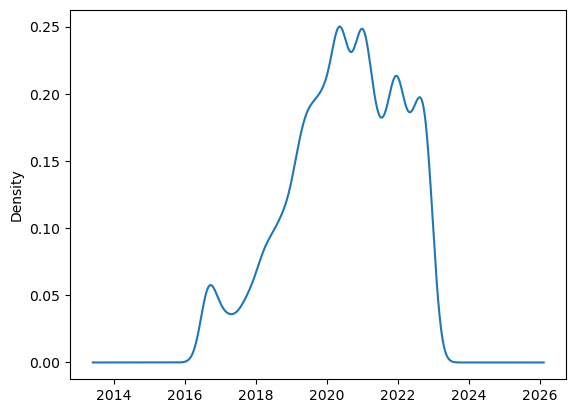

In [46]:
def plot_date_density(df, date_column):
    # https://stackoverflow.com/questions/31348737/how-to-plot-kernel-density-plot-of-dates-in-pandas
    start_date = '2016-1-1'
    df['rel'] = df[date_column] - pd.to_datetime(start_date)
    df.rel = df.rel.astype('timedelta64[D]')
    df['year_as_float'] = pd.to_datetime(start_date).year + df.rel / 365.

    df['year_as_float'].plot.density()

plot_date_density(ai_posts_featurized, 'last_activity_date')

In [13]:
from collections import Counter

all_tags = []
for tag_str in ai_posts_featurized['tags'].values:
    if (tag_str == tag_str) and tag_str != None: # not NaN or None
        tags = tag_str.split(';')
        all_tags.extend(tags) # add the elements of 'tags' to 'all_tags'
    
# len(all_tags) # 36223

top_tag_counts = Counter(all_tags).most_common(100)
top_tag_counts

StatementMeta(, 0a32367b-eb7d-4991-8bd9-0f8a55b6ab5d, 20, Finished, Available)

[('neural-networks', 2333),
 ('reinforcement-learning', 2200),
 ('machine-learning', 2100),
 ('deep-learning', 1804),
 ('convolutional-neural-networks', 1067),
 ('natural-language-processing', 628),
 ('reference-request', 453),
 ('computer-vision', 450),
 ('deep-rl', 446),
 ('comparison', 430),
 ('classification', 426),
 ('training', 411),
 ('terminology', 376),
 ('q-learning', 354),
 ('recurrent-neural-networks', 334),
 ('python', 324),
 ('tensorflow', 320),
 ('dqn', 309),
 ('papers', 306),
 ('image-recognition', 278),
 ('long-short-term-memory', 270),
 ('ai-design', 265),
 ('datasets', 251),
 ('objective-functions', 250),
 ('keras', 240),
 ('game-ai', 238),
 ('backpropagation', 236),
 ('math', 227),
 ('generative-adversarial-networks', 220),
 ('object-detection', 210),
 ('optimization', 207),
 ('definitions', 197),
 ('gradient-descent', 188),
 ('transformer', 186),
 ('applications', 184),
 ('markov-decision-process', 183),
 ('pytorch', 180),
 ('philosophy', 179),
 ('agi', 178),
 ('po

In [14]:
flag_cols = {}

top_tags = [tt[0] for tt in top_tag_counts]

tag_strings = ['' if ts is None else ts for ts in ai_posts_featurized['tags'].values]

# len(tag_strings) # 22515
# Counter(tag_strings).most_common(1) # [('', 11808)]; about half of the posts have no tags

for tag in top_tags:
    flag_cols[tag] = [1 if tag in tag_str.split(';') else 0 for tag_str in tag_strings ]
    # This way 'search' does not match 'research'

flags_pdf = pd.DataFrame(flag_cols).reset_index().rename(columns={'index': 'post_id'})
flags_pdf

# flags_pdf.sum(axis=0)  # get sum of each column

StatementMeta(, 0a32367b-eb7d-4991-8bd9-0f8a55b6ab5d, 21, Finished, Available)

,post_id,neural-networks,reinforcement-learning,machine-learning,deep-learning,convolutional-neural-networks,natural-language-processing,reference-request,computer-vision,deep-rl,...,neat,temporal-difference-methods,transfer-learning,intelligent-agent,multilayer-perceptrons,minimax,notation,yolo,pattern-recognition,alphazero
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22510,22510,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22511,22511,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22512,22512,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22513,22513,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
tags_rdd = sc.parallelize(top_tags)

X_all = [v for v in ai_posts_featurized['text_embedding']]
my_Cs = 10**np.linspace(-3, 1, 5)

def predict_tag(tag):
    y_all = [f for f in flags_pdf[tag]]

    clf = LogisticRegressionCV(Cs=my_Cs, cv=3, max_iter=5000, n_jobs=-1, scoring='roc_auc').fit(X_all, y_all) # normally use at least cv=5

    scores = clf.predict_proba(X_all)[:,1]
    return (tag, scores, clf.C_[0], clf)

tag_results = tags_rdd.map(predict_tag).collect()

scores_pdf = pd.DataFrame({r[0]:r[1] for r in tag_results})
scores_pdf

StatementMeta(, 0a32367b-eb7d-4991-8bd9-0f8a55b6ab5d, 22, Finished, Available)

,neural-networks,reinforcement-learning,machine-learning,deep-learning,convolutional-neural-networks,natural-language-processing,reference-request,computer-vision,deep-rl,comparison,...,neat,temporal-difference-methods,transfer-learning,intelligent-agent,multilayer-perceptrons,minimax,notation,yolo,pattern-recognition,alphazero
0,0.007847,0.003398,0.027848,0.019462,0.000218,0.014600,0.010017,0.001154,0.002240,0.012820,...,0.000644,1.885286e-04,0.000101,0.000043,0.000049,0.000325,0.000207,0.000249,0.002486,0.000052
1,0.021124,0.002956,0.025237,0.053794,0.056002,0.001250,0.004422,0.060807,0.002638,0.003513,...,0.000012,1.048780e-06,0.000164,0.000077,0.000141,0.001162,0.000640,0.003110,0.008659,0.000009
2,0.007511,0.001182,0.016101,0.004185,0.000901,0.000408,0.009809,0.002683,0.000344,0.001575,...,0.000211,8.845995e-07,0.000013,0.003716,0.000161,0.000030,0.000332,0.000501,0.000453,0.000056
3,0.040307,0.000711,0.036080,0.089172,0.004197,0.135231,0.009482,0.012856,0.003335,0.008820,...,0.000072,4.313727e-05,0.000024,0.000786,0.000074,0.000212,0.001870,0.001741,0.001842,0.000024
4,0.001028,0.331478,0.007889,0.004701,0.000085,0.000554,0.002442,0.000135,0.059302,0.003229,...,0.000012,2.217458e-01,0.000022,0.000071,0.000112,0.001088,0.005344,0.000065,0.000140,0.000026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22510,0.000684,0.009841,0.008988,0.002182,0.000271,0.019998,0.003155,0.001876,0.003563,0.098730,...,0.002248,2.903882e-06,0.000002,0.000021,0.000877,0.003796,0.000410,0.000856,0.000554,0.000022
22511,0.002660,0.002002,0.006778,0.010892,0.000309,0.032472,0.004161,0.000803,0.030111,0.000610,...,0.000038,1.005424e-04,0.000008,0.000010,0.000123,0.000424,0.000101,0.000460,0.000593,0.000010
22512,0.017912,0.003427,0.095784,0.055236,0.001046,0.522945,0.017857,0.005786,0.006666,0.001085,...,0.000016,1.440812e-04,0.000030,0.000442,0.001600,0.000864,0.001932,0.000790,0.001160,0.000001
22513,0.009527,0.002860,0.018250,0.024578,0.000529,0.381439,0.008281,0.000752,0.002128,0.000626,...,0.000028,9.221004e-03,0.000013,0.000163,0.000505,0.000587,0.003248,0.000599,0.000454,0.000042


In [16]:
print(Counter([r[2] for r in tag_results])) # count the times each regularization penalty was selected

StatementMeta(, 0a32367b-eb7d-4991-8bd9-0f8a55b6ab5d, 23, Finished, Available)

Counter({0.1: 75, 1.0: 24, 0.01: 1})


# ROC Curves

Note that these curves show the performance on the training set, not on held-out data.

In [17]:
tag_auc = {tag: metrics.roc_auc_score(flags_pdf[tag].values, scores_pdf[tag].values) for tag in top_tags}

sorted_tag_auc = {k: v for k, v in sorted(tag_auc.items(), key=lambda item: item[1], reverse=True)}

sorted_tag_auc

StatementMeta(, 0a32367b-eb7d-4991-8bd9-0f8a55b6ab5d, 24, Finished, Available)

{'alphazero': 0.9992622823036836,
 'neat': 0.9988641526578828,
 'variational-autoencoder': 0.9978804771202816,
 'temporal-difference-methods': 0.9971218534194698,
 'geometric-deep-learning': 0.996135211009771,
 'intelligent-agent': 0.9959872798408801,
 'transfer-learning': 0.9949747348547948,
 'actor-critic-methods': 0.994296512927626,
 'word-embedding': 0.993950429639885,
 'sutton-barto': 0.9939280142634276,
 'proximal-policy-optimization': 0.9935731596711123,
 'minimax': 0.9927528636081332,
 'proofs': 0.9925781675452267,
 'computational-learning-theory': 0.9919697802333813,
 'generative-adversarial-networks': 0.9917937164875941,
 'bert': 0.9910922596491675,
 'convolution': 0.9902121633316725,
 'monte-carlo-tree-search': 0.9891856880219682,
 'transformer': 0.9890797299620485,
 'graph-neural-networks': 0.9887045550904355,
 'attention': 0.9881691257338507,
 'yolo': 0.9879788125812448,
 'policies': 0.98623219191006,
 'activation-functions': 0.9862060707484562,
 'multilayer-perceptrons': 

StatementMeta(, 0a32367b-eb7d-4991-8bd9-0f8a55b6ab5d, 25, Finished, Available)

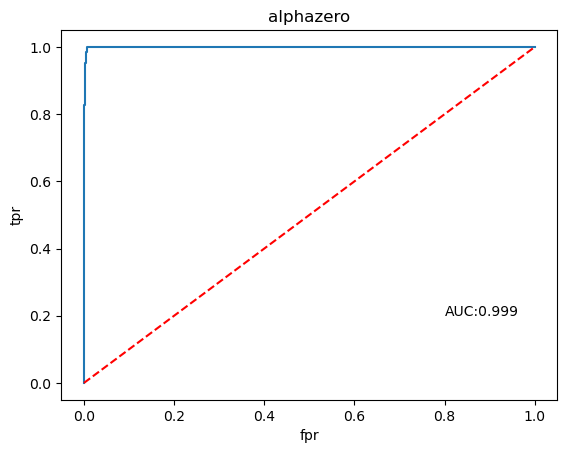

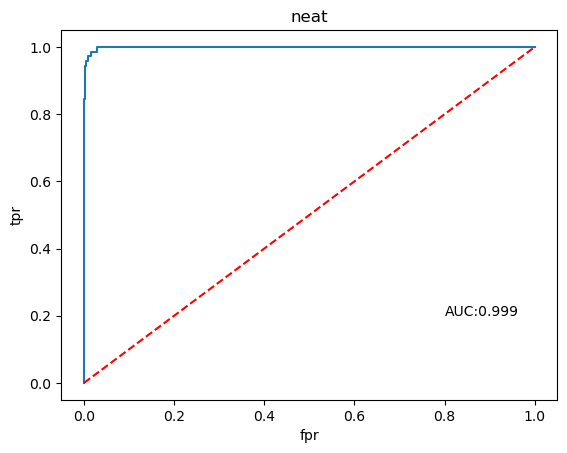

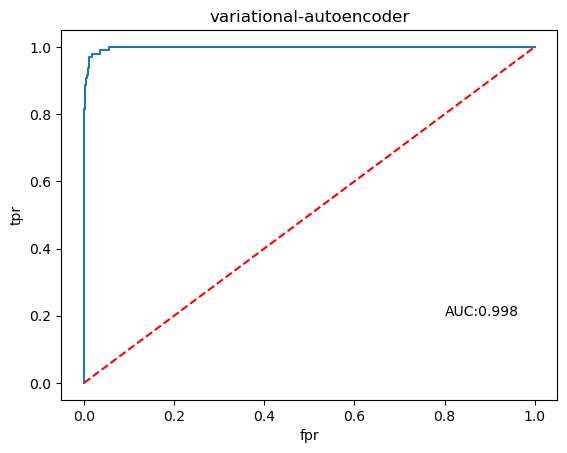

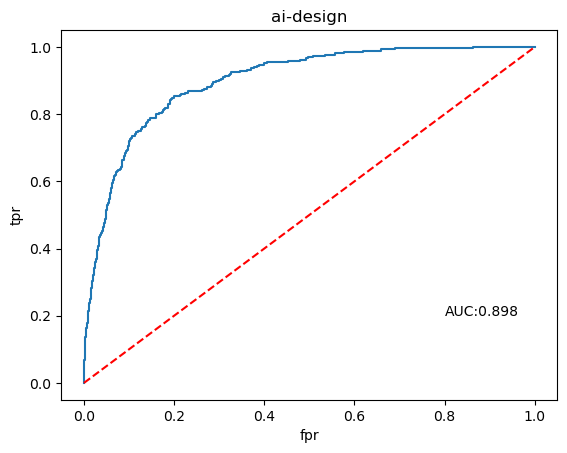

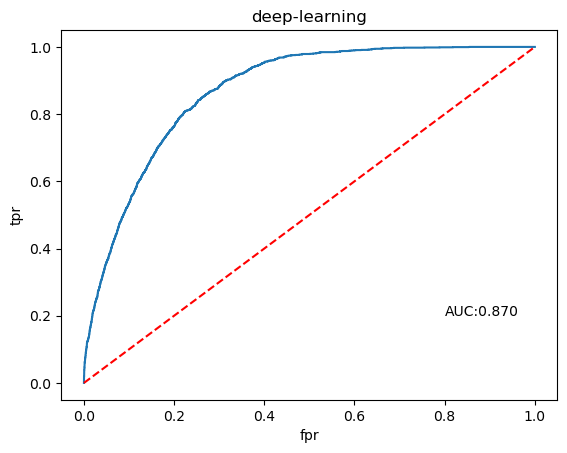

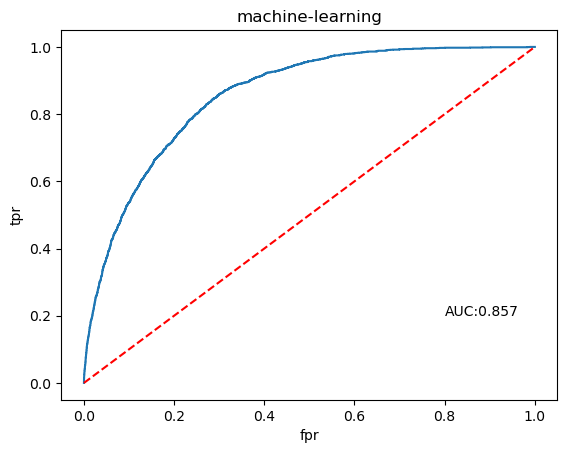

In [18]:
def plot_auc(labels, scores, title=''):
    fpr, tpr, thresholds = metrics.roc_curve(labels, scores)
    auc = metrics.roc_auc_score(labels, scores)

    plt.plot(fpr, tpr)
    plt.xlabel('fpr')
    plt.ylabel('tpr')
    plt.plot([0, 1], [0, 1],'r--')
    plt.text(0.8, 0.2, f"AUC:{auc:0.3f}")
    plt.title(title)
    plt.show()


sorted_tags = list(sorted_tag_auc.keys())

# Most predictable tags
for tag in list(sorted_tag_auc.keys())[:3]:
    plot_auc(flags_pdf[tag].values, scores_pdf[tag].values, title=tag)

# Least predictable tags
for tag in list(sorted_tag_auc.keys())[-3:]:
    plot_auc(flags_pdf[tag].values, scores_pdf[tag].values, title=tag)

In [68]:
def show_top_and_bottom(tag, num_examples=10):
    """ Display the highest scoring unflagged examples (most probable false negatives)
    and the lowest scoring flagged examples (most probable false positives)"""
    
    from pandas import option_context

    keep_cols = ['text'] # , 'tags', 'last_activity_date']
    df = ai_posts_featurized[keep_cols].copy()
    df['flag'] = flags_pdf[tag]
    df['score'] = scores_pdf[tag]

    df = df.sort_values('score', ascending=False)

    with option_context('display.max_colwidth', 0):
        print("Highest scoring unflagged examples:")
        display(df[df['flag'] == 0].head(num_examples))
        print("Lowest scoring flagged examples:")
        display(df[df['flag'] == 1].tail(num_examples))


show_top_and_bottom('alphazero')

StatementMeta(, 0a32367b-eb7d-4991-8bd9-0f8a55b6ab5d, 76, Finished, Available)

Highest scoring unflagged examples:


/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:604: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  [(c, t) for (_, c), t in zip(pdf_slice.iteritems(), arrow_types)]


SynapseWidget(Synapse.DataFrame, 7146ddd7-af7b-47c3-a6f4-70ef915c0619)

Lowest scoring flagged examples:


SynapseWidget(Synapse.DataFrame, 0eb0fef8-06a5-47d4-8c4d-8a6f78e65e11)

In [69]:
show_top_and_bottom('machine-learning')

StatementMeta(, 0a32367b-eb7d-4991-8bd9-0f8a55b6ab5d, 77, Finished, Available)

Highest scoring unflagged examples:


/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:604: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  [(c, t) for (_, c), t in zip(pdf_slice.iteritems(), arrow_types)]


SynapseWidget(Synapse.DataFrame, 12f2b753-fa05-4377-98a8-bb29e419373a)

Lowest scoring flagged examples:


SynapseWidget(Synapse.DataFrame, 78fc15e3-4735-49ed-9b24-617edc397085)

StatementMeta(, 0a32367b-eb7d-4991-8bd9-0f8a55b6ab5d, 26, Finished, Available)

/home/trusted-service-user/cluster-env/trident_env/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


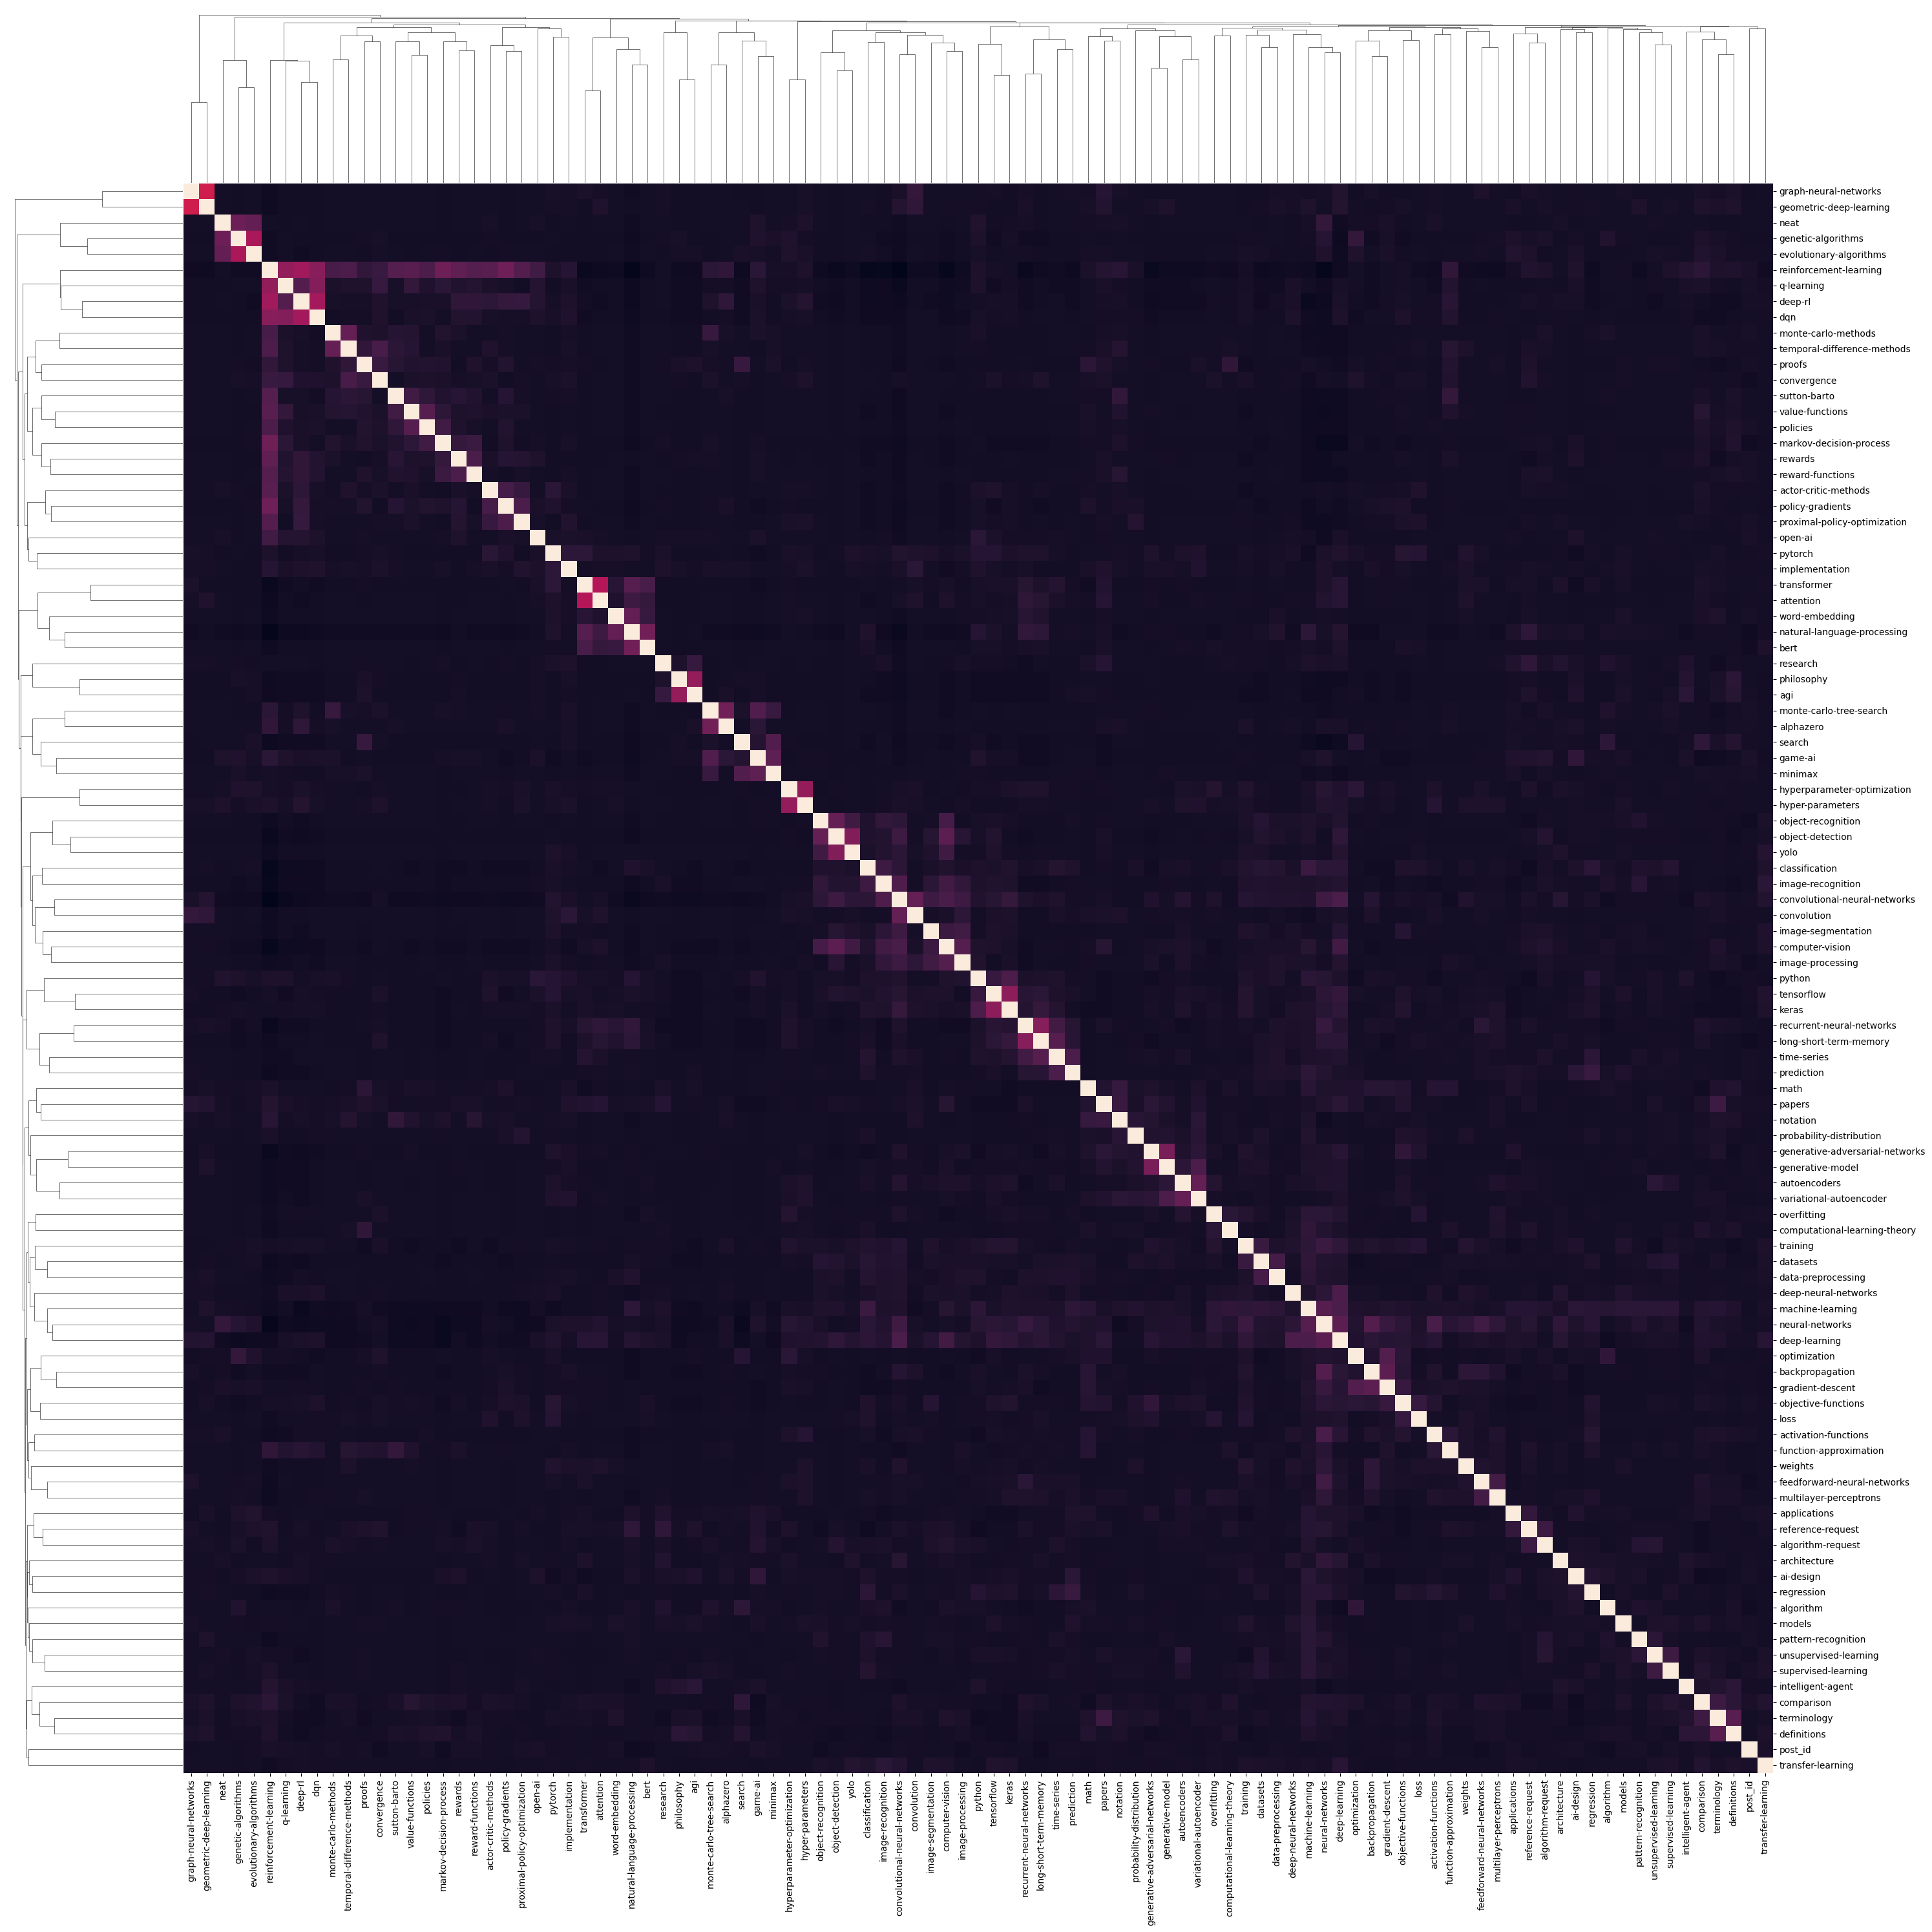

In [19]:
sns.clustermap(flags_pdf.corr(), figsize=(30,30), dendrogram_ratio=0.1, cbar_pos=None)

StatementMeta(, 0a32367b-eb7d-4991-8bd9-0f8a55b6ab5d, 27, Finished, Available)

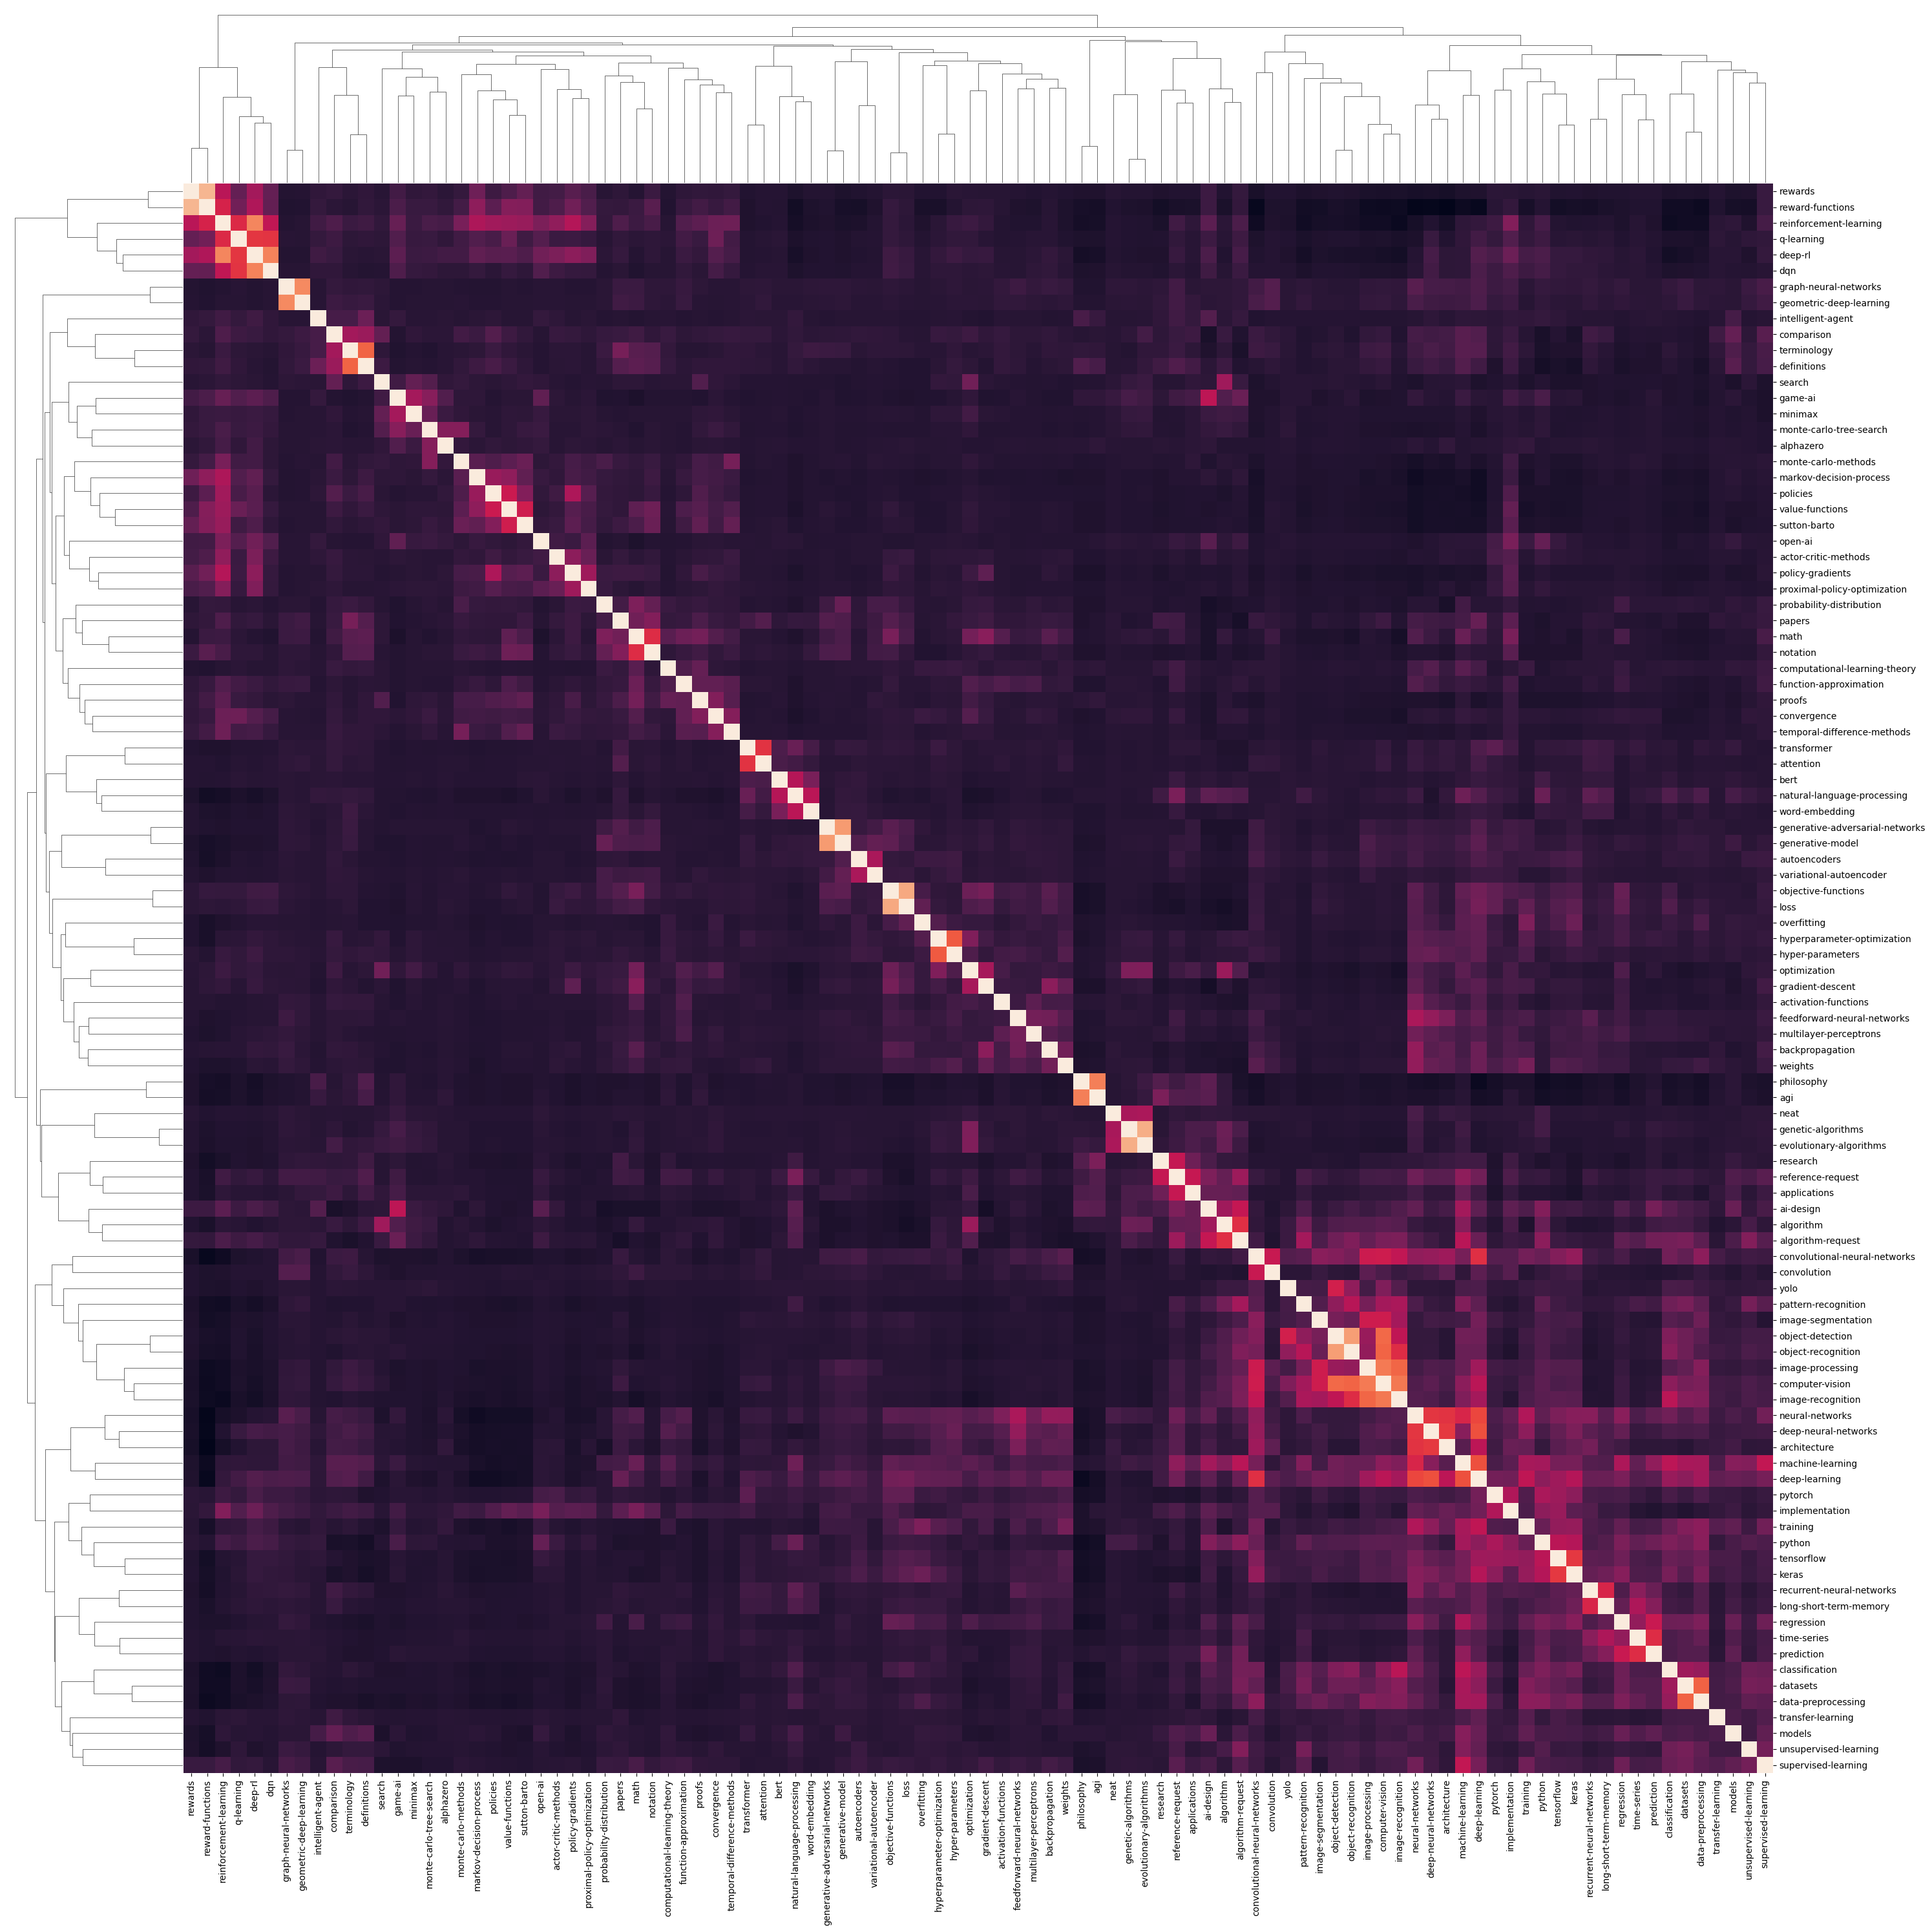

In [20]:
sns.clustermap(scores_pdf.corr(), figsize=(30,30), dendrogram_ratio=0.1, cbar_pos=None)

In [21]:
M = flags_pdf.corr()
M['machine-learning'][M['machine-learning'] > 0.1]

StatementMeta(, 0a32367b-eb7d-4991-8bd9-0f8a55b6ab5d, 28, Finished, Available)

neural-networks     0.180606
machine-learning    1.000000
deep-learning       0.150619
classification      0.105670
Name: machine-learning, dtype: float64

# What threshold gives 95% recall?
We'll assume that most incorrect tags are just missing.

In [22]:
def threshold_at_recall(tag, recall_level=0.95):
    scores = scores_pdf[tag]
    flags = flags_pdf[tag]

    # pd.DataFrame({'score':scores, 'flag': flags}).sort_values('score')

    fpr, tpr, thresholds = metrics.roc_curve(flags, scores)
    auc = metrics.roc_auc_score(flags, scores)

    roc_df = pd.DataFrame({'fpr':fpr, 'tpr': tpr, 'threshold': thresholds})
    threshold = max(roc_df[roc_df['tpr'] > recall_level]['threshold'])

    return {'tag': tag, 'threshold': threshold, 'auc': auc}


tag_threshold_auc = pd.DataFrame([threshold_at_recall(tag) for tag in top_tags]).sort_values('auc').set_index('tag')
tag_threshold_auc

StatementMeta(, 0a32367b-eb7d-4991-8bd9-0f8a55b6ab5d, 29, Finished, Available)

,threshold,auc
tag,,
machine-learning,0.042453,0.856595
deep-learning,0.044952,0.870114
ai-design,0.006773,0.897961
reference-request,0.008523,0.901037
deep-neural-networks,0.005481,0.910584
...,...,...
geometric-deep-learning,0.007330,0.996135
temporal-difference-methods,0.021858,0.997122
variational-autoencoder,0.026802,0.997880


In [23]:
tag_threshold_auc.sort_values('threshold')

StatementMeta(, 0a32367b-eb7d-4991-8bd9-0f8a55b6ab5d, 30, Finished, Available)

,threshold,auc
tag,,
architecture,0.002375,0.929633
convergence,0.003448,0.951302
supervised-learning,0.003782,0.929846
generative-model,0.003831,0.949976
algorithm,0.003844,0.916981
...,...,...
machine-learning,0.042453,0.856595
deep-learning,0.044952,0.870114
neat,0.053505,0.998864


In [24]:
predicted_flag_dict = {}
for tag in top_tags:
    threshold = tag_threshold_auc.loc[tag]['threshold']
    predicted_flag_dict[tag] = [int(b) for b in (scores_pdf[tag] >= threshold)]

predicted_flag_pdf = pd.DataFrame(predicted_flag_dict).reset_index().rename(columns={'index': 'post_id'})
predicted_flag_pdf

StatementMeta(, 0a32367b-eb7d-4991-8bd9-0f8a55b6ab5d, 31, Finished, Available)

,post_id,neural-networks,reinforcement-learning,machine-learning,deep-learning,convolutional-neural-networks,natural-language-processing,reference-request,computer-vision,deep-rl,...,neat,temporal-difference-methods,transfer-learning,intelligent-agent,multilayer-perceptrons,minimax,notation,yolo,pattern-recognition,alphazero
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
2,2,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,1,0,0,0,0,0,0,1,...,0,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22510,22510,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22511,22511,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
22512,22512,0,0,1,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
22513,22513,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
tag_counts = pd.DataFrame({'original': flags_pdf[top_tags].sum(axis=0), 
                           'predicted': predicted_flag_pdf[top_tags].sum(axis=0)})
tag_counts['ratio'] = tag_counts['predicted']/tag_counts['original']
tag_counts.sort_values('ratio')

StatementMeta(, 0a32367b-eb7d-4991-8bd9-0f8a55b6ab5d, 32, Finished, Available)

,original,predicted,ratio
alphazero,64,127,1.984375
neat,71,156,2.197183
reinforcement-learning,2200,5494,2.497273
variational-autoencoder,97,359,3.701031
neural-networks,2333,9350,4.007715
...,...,...,...
implementation,106,7015,66.179245
algorithm,126,8463,67.166667
convergence,82,5683,69.304878
supervised-learning,91,6960,76.483516


StatementMeta(, 0a32367b-eb7d-4991-8bd9-0f8a55b6ab5d, 33, Finished, Available)

(-24.464499999999997, 2446.45)

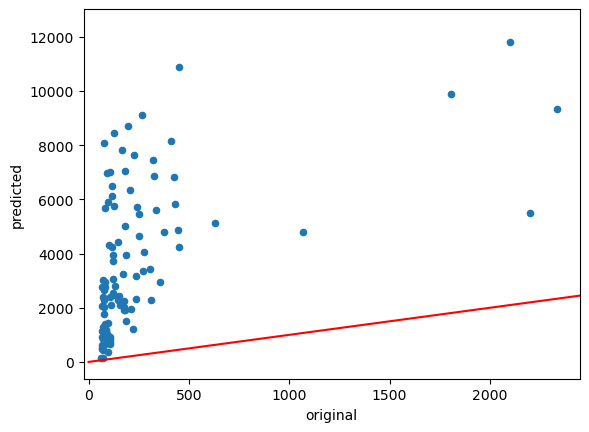

In [26]:
ax = tag_counts.plot.scatter(x='original', y='predicted')

max_x = max(ax.get_xlim()) # includes padding
max_y = max(ax.get_ylim())
max_val = max( max_x, max_y )

ax.plot([0, max_val], [0, max_val], c='red')
ax.set_xlim( -(max_x/100), max_x)

In [70]:
tag_counts[tag_counts['original'] > 2000]

StatementMeta(, 0a32367b-eb7d-4991-8bd9-0f8a55b6ab5d, 78, Finished, Available)

,original,predicted,ratio
neural-networks,2333,9350,4.007715
reinforcement-learning,2200,5494,2.497273
machine-learning,2100,11820,5.628571


# Co-occurrence

In [27]:
def get_item_pair_stats(item_pair_df):
    # item_pair_df must have columns named 'basket', and 'item'.
    
    import sqlite3 # we're using this for portability; you can run this code on your favorite SQL database.

    db = sqlite3.connect(":memory:")
    
    item_pair_df.to_sql("basket_item", db, if_exists="replace")


    ITEM_PAIR_STATS_QUERY = """with 
      bi as (
        select basket, item
          from basket_item
          group by basket, item  -- be sure we only count one of each kind of item per basket
      ),
      item_counts as (
        select item, count(*) item_count -- same as the number of baskets containing this item (see above)
          from bi
          group by item
      ),
      bi_count as (
        select bi.*, ic.item_count  -- basket, item, item_count
          from bi
            join item_counts ic on bi.item=ic.item
      ),
      ips as (
          select bi1.item item1, bi2.item item2,
                  bi1.item_count item1_count, bi2.item_count item2_count,
                  count(*) as both_count              
              from bi_count bi1
                join bi_count bi2  -- joining the table to itself
                  on bi1.basket = bi2.basket  -- two items in the same basket
                  and bi1.item != bi2.item    -- don't count the item being in the basket with itself
              group by bi1.item, bi1.item_count, 
                       bi2.item, bi2.item_count
      ),
      cc as (
        SELECT item1, item2, item1_count, item2_count, both_count,
              CAST(item1_count AS FLOAT)/(select count(distinct basket) from basket_item) as item1_prevalence, -- fraction of all baskets with item1
              CAST(item2_count AS FLOAT)/(select count(distinct basket) from basket_item) as item2_prevalence, -- fraction of all baskets with item2
              CAST(both_count AS FLOAT)/CAST(item1_count AS FLOAT) AS confidence  -- fraction of baskets with item1 that also have item2
          FROM ips
      )
    select *, confidence/item2_prevalence lift from cc
    """

    return pd.read_sql_query(ITEM_PAIR_STATS_QUERY, db)


def get_nodes_and_edges_from_item_pair_stats(cooccurrence_pdf):
    """
    Convert a Pandas dataframe of item-pair statistics to separate dataframes for nodes and edges.
    """
    from collections import Counter
    
    item_stats = {r['item1']:{'count':r['item1_count'], 'prevalence':r['item1_prevalence']} 
                    for idx, r in cooccurrence_pdf.iterrows()}
 
    item_stats.update({r['item2']:{'count':r['item2_count'], 'prevalence':r['item2_prevalence']} 
                    for idx, r in cooccurrence_pdf.iterrows()})
 
    nodes_df = pd.DataFrame([{'label':k,'count':v['count'], 'prevalence':v['prevalence']}  
                    for k,v in item_stats.items()])
    nodes_df['id'] = nodes_df.index
   
    edges_df = cooccurrence_pdf.copy()
    node_id = {r['label']:r['id'] for idx, r in nodes_df.iterrows()}
    edges_df['from'] = [node_id[nn] for nn in edges_df['item1']]
    edges_df['to'] = [node_id[nn] for nn in edges_df['item2']]
    
    print("Your graph will have {0} nodes and {1} edges.".format( len(nodes_df), len(edges_df) ))
 
    return nodes_df, edges_df[[ 'from', 'to', 'both_count', 'confidence', 'lift']]


def get_vis_js_html(nodes_df, edges_df):
    """
    Generate HTML encoding vis_js graph from Pandas dataframes of nodes and edges.
    """
    nodes_str = nodes_df.to_json(orient='records')
    edges_str = edges_df.to_json(orient='records')
    
    max_weight = max(edges_df['weight'])

    html_string = ( 
    f'    <script type="text/javascript">NODE_LIST={nodes_str};FULL_EDGE_LIST={edges_str};</script>\n'
    '\n'
        '\n'
    '        <script type="text/javascript" src="https://unpkg.com/vis-network/standalone/umd/vis-network.min.js"></script>\n'
    '        <script type="text/javascript">\n'
    '            function hello(){console.info("hello")}\n'
    '\n'
    '            const sign_color = {pos:"blue", neg:"red", zero:"black"}\n'
    '            const options = {physics:{maxVelocity: 1, minVelocity: 0.01}}\n'
    '            var edgeFilterSlider\n'
    '            var mynetwork\n'
    '            var motion_flag = false\n'
    '            function toggle_motion(){\n'
    '                motion_flag = !motion_flag\n'
    '                mynetwork.setOptions( { physics: motion_flag } )\n'
    '            }\n'
    '\n'
    '            function edgesFilter(edge){\n'
    '                return edge.value >= edgeFilterSlider.value\n'
    '            }\n'
    '\n'
    '            function init_network(){\n'
    '                document.getElementById("min_edge_weight_display").value = 0.5\n'
    '                document.getElementById("min_edge_weight").onchange = function(){\n'
    '                    document.getElementById("min_edge_weight_display").value = this.value\n'
    '                }\n'
    '\n'
    '                edgeFilterSlider = document.getElementById("min_edge_weight")\n'
    '                edgeFilterSlider.addEventListener("change", (e) => {edgesView.refresh()})\n'
    '                var container = document.getElementById("mynetwork")\n'
    '                var EDGE_LIST = []\n'
    '                for (var i = 0; i < FULL_EDGE_LIST.length; i++) {\n'
    '                    var edge = FULL_EDGE_LIST[i]\n'
    '                    edge["value"] = Math.abs(edge["weight"])\n'
    '                    edge["title"] = "weight " + edge["weight"]\n'
    '                    edge["sign"] = (edge["weight"] < 0) ? "neg" : "pos";\n'
    '                    edge["color"] = {color: sign_color[edge["sign"]] };\n'
    '                    edge["arrows"] = "to"\n'
    '                    EDGE_LIST.push(edge)\n'
    '                }\n'
    '\n'
    '                var nodes = new vis.DataSet(NODE_LIST)\n'
    '                var edges = new vis.DataSet(EDGE_LIST)\n'
    '                var nodesView = new vis.DataView(nodes)\n'
    '                var edgesView = new vis.DataView(edges, { filter: edgesFilter })\n'
    '                var data = { nodes: nodesView, edges: edgesView }\n'
    '                mynetwork = new vis.Network(container, data, options)\n'
    '\n'
    '            }\n'
    '            init_network()\n'
    '        </script>\n'
    '        <style type="text/css">#mynetwork {width: 100%; height: 500px; border: 3px}</style>\n'
    '        <button onclick=toggle_motion()>Toggle motion</button>\n'
    '        <div class="slidercontainer">\n'
    '            <label>minimum edge weight:\n'
    f'                <input type="range" min="0" max="{max_weight}" value="{max_weight/2}" step="{max_weight/100}" class="slider" id="min_edge_weight">\n'
    '                <input type="text" id="min_edge_weight_display" size="2">\n'
    '            </label>\n'
    '        </div>\n'
    '        <div id="mynetwork"></div>\n'

    )
    return html_string
        
    
def export_to_vis_js(nodes_df, edges_df, title, html_file_name):
    """
    Generate vis_js graph from Pandas dataframes of nodes and edges, and write to HTML file.
    """
    
    vis_js_html = get_vis_js_html(nodes_df, edges_df)
    page_html =  ('<!DOCTYPE html>\n'
        '<html lang="en">\n'
        '    <head>\n'
        f'       <title>{title}</title>\n'
        '    </head>\n'
        '    <body onload=init_network()>\n'
        f'{vis_js_html}'
        '\n'
        '    </body>\n'
        '</html>\n')
    
    with open(html_file_name, "wt") as html_file: 
        html_file.write(page_html)

StatementMeta(, 0a32367b-eb7d-4991-8bd9-0f8a55b6ab5d, 34, Finished, Available)

In [28]:
flags_long = pd.melt(flags_pdf, id_vars='post_id')
flags_long = flags_long[flags_long['value'] == 1]
flags_long = flags_long[['post_id', 'variable']].sort_values('post_id')

flags_long

StatementMeta(, 0a32367b-eb7d-4991-8bd9-0f8a55b6ab5d, 35, Finished, Available)

,post_id,variable
337757,32,python
540392,32,keras
90112,52,convolutional-neural-networks
247717,52,training
923167,52,deep-neural-networks
...,...,...
180093,22488,computer-vision
1035684,22509,image-processing
22512,22512,neural-networks
135087,22512,natural-language-processing


In [29]:
flags_ips = get_item_pair_stats(flags_long.rename(columns={'post_id':'basket', 'variable':'item'}))

flags_ips.sort_values('confidence', ascending=False)[0:15]

StatementMeta(, 0a32367b-eb7d-4991-8bd9-0f8a55b6ab5d, 36, Finished, Available)

,item1,item2,item1_count,item2_count,both_count,item1_prevalence,item2_prevalence,confidence,lift
4518,sutton-barto,reinforcement-learning,80,2200,78,0.007860,0.216152,0.975000,4.510705
4371,reward-functions,reinforcement-learning,79,2200,77,0.007762,0.216152,0.974684,4.509241
4409,rewards,reinforcement-learning,120,2200,112,0.011790,0.216152,0.933333,4.317939
5002,value-functions,reinforcement-learning,98,2200,91,0.009629,0.216152,0.928571,4.295909
4550,temporal-difference-methods,reinforcement-learning,70,2200,64,0.006878,0.216152,0.914286,4.229818
3619,policy-gradients,reinforcement-learning,178,2200,161,0.017489,0.216152,0.904494,4.184520
3576,policies,reinforcement-learning,77,2200,68,0.007565,0.216152,0.883117,4.085620
83,actor-critic-methods,reinforcement-learning,107,2200,94,0.010513,0.216152,0.878505,4.064282
3993,q-learning,reinforcement-learning,354,2200,310,0.034781,0.216152,0.875706,4.051335
3790,proximal-policy-optimization,reinforcement-learning,96,2200,84,0.009432,0.216152,0.875000,4.048068


In [30]:
flags_nodes, flags_edges = get_nodes_and_edges_from_item_pair_stats( flags_ips[ flags_ips['both_count'] > 50 ] )

flags_nodes['title'] = flags_nodes['label']  # mouseover text
flags_edges['weight'] = flags_edges['confidence']

StatementMeta(, 0a32367b-eb7d-4991-8bd9-0f8a55b6ab5d, 37, Finished, Available)

Your graph will have 54 nodes and 196 edges.


## Co-occurrence graph from original tags

In [31]:
vis_js_html = get_vis_js_html(flags_nodes, flags_edges)
displayHTML(vis_js_html)

StatementMeta(, 0a32367b-eb7d-4991-8bd9-0f8a55b6ab5d, 38, Finished, Available)

## Co-occurrence graph from predicted tags

In [32]:
predicted_flag_long = pd.melt(predicted_flag_pdf, id_vars='post_id')
predicted_flag_long = predicted_flag_long[predicted_flag_long['value'] == 1]
predicted_flag_long = predicted_flag_long[['post_id', 'variable']].sort_values('post_id')

predicted_ips = get_item_pair_stats(predicted_flag_long.rename(columns={'post_id':'basket', 'variable':'item'}))
predicted_ips.sort_values('confidence', ascending=False)[0:15]

predicted_nodes, predicted_edges = get_nodes_and_edges_from_item_pair_stats( predicted_ips[ (predicted_ips['both_count'] > 50) & (predicted_ips['lift'] > 4) ] )
 #  & (predicted_ips['lift'] > 4)

predicted_nodes['title'] = predicted_nodes['label']  # mouseover text
predicted_edges['weight'] = predicted_edges['confidence']

vis_js_html = get_vis_js_html(predicted_nodes, predicted_edges[predicted_edges['weight'] > 0.25])
displayHTML(vis_js_html)

StatementMeta(, 0a32367b-eb7d-4991-8bd9-0f8a55b6ab5d, 39, Finished, Available)

Your graph will have 61 nodes and 294 edges.
